In [53]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import torch
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS
from neuralforecast.losses.pytorch import MAE, RMSE
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error,
)
from utilsforecast.processing import backtest_splits

warnings.filterwarnings("ignore")

In [3]:
if torch.cuda.is_available():
    device = torch.cuda.get_device_name(0)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: NVIDIA GeForce RTX 5090


### Load dataset

In [11]:
df = pd.read_csv(
    "data/dataset.csv",parse_dates=[0],
    date_format="%Y-%m-%d %H:%M:%S",
)

# Format for forecasting library
df = df.rename(columns={"timestamp": "ds", "demanda_real": "y"})
df.insert(1, column="unique_id", value="demanda")
df

,ds,unique_id,y,demanda_ejecutado,prog_dia,reprog_dia
0,2023-01-01 00:15:00,demanda,6067.10602,6120.780000,6184.317140,6166.156910
1,2023-01-01 00:30:00,demanda,6045.22291,6120.780000,6184.317140,6166.156910
2,2023-01-01 00:45:00,demanda,5999.45558,6065.846695,6158.326410,6140.048065
3,2023-01-01 01:00:00,demanda,5965.07526,6010.913390,6132.335680,6113.939220
4,2023-01-01 01:15:00,demanda,5913.92014,5978.873195,6105.828795,6087.665005
...,...,...,...,...,...,...
105211,2025-12-31 23:00:00,demanda,6864.23513,6927.542140,7110.844180,6893.717490
105212,2025-12-31 23:15:00,demanda,6859.99152,6901.229125,6972.234775,6756.729290
105213,2025-12-31 23:30:00,demanda,6816.54505,6874.916110,6833.625370,6619.741090
105214,2025-12-31 23:45:00,demanda,6727.11981,6710.783080,6740.020935,6526.726935


### Split train / test

In [12]:
# Split training and test set
train_start = "2023-01-01 00:15:00"
test_start = "2025-12-01 00:15:00"

df_train = df.loc[df["ds"]<test_start]
df_test = df.loc[df["ds"]>=test_start]
df_train

,ds,unique_id,y,demanda_ejecutado,prog_dia,reprog_dia
0,2023-01-01 00:15:00,demanda,6067.10602,6120.780000,6184.317140,6166.156910
1,2023-01-01 00:30:00,demanda,6045.22291,6120.780000,6184.317140,6166.156910
2,2023-01-01 00:45:00,demanda,5999.45558,6065.846695,6158.326410,6140.048065
3,2023-01-01 01:00:00,demanda,5965.07526,6010.913390,6132.335680,6113.939220
4,2023-01-01 01:15:00,demanda,5913.92014,5978.873195,6105.828795,6087.665005
...,...,...,...,...,...,...
102235,2025-11-30 23:00:00,demanda,7026.78673,7056.225320,6889.757990,6895.659880
102236,2025-11-30 23:15:00,demanda,6920.55285,6907.513835,6810.505805,6815.350475
102237,2025-11-30 23:30:00,demanda,6801.19111,6758.802350,6731.253620,6735.041070
102238,2025-11-30 23:45:00,demanda,6740.88761,6743.091035,6664.227015,6666.786230


In [13]:
df_test

,ds,unique_id,y,demanda_ejecutado,prog_dia,reprog_dia
102240,2025-12-01 00:15:00,demanda,6568.54212,6643.877560,6516.795190,6564.718655
102241,2025-12-01 00:30:00,demanda,6499.00775,6560.375400,6436.389970,6537.848600
102242,2025-12-01 00:45:00,demanda,6413.25015,6538.137760,6387.059425,6489.395025
102243,2025-12-01 01:00:00,demanda,6421.08217,6515.900120,6337.728880,6440.941450
102244,2025-12-01 01:15:00,demanda,6348.84309,6457.709600,6306.607900,6408.618970
...,...,...,...,...,...,...
105211,2025-12-31 23:00:00,demanda,6864.23513,6927.542140,7110.844180,6893.717490
105212,2025-12-31 23:15:00,demanda,6859.99152,6901.229125,6972.234775,6756.729290
105213,2025-12-31 23:30:00,demanda,6816.54505,6874.916110,6833.625370,6619.741090
105214,2025-12-31 23:45:00,demanda,6727.11981,6710.783080,6740.020935,6526.726935


### Configure hyperparameters search space

In [ ]:
# Configure horizon
horizon_hours = 12
horizon = horizon_hours * 4 # 12 hours to 48 points every 15 minutes

def config_nhits(trial: optuna.Trial) -> dict:
    """Load configuration for hypar optimization."""
    return {
            "exclude_insample_y": True, # Exclude y (demanda real) from features
            "start_padding_enabled": False,

            # Try different input sizes
            "input_size": trial.suggest_categorical(
                "input_size", [i*horizon for i in range(1, 6, 1)],
            ),
            "hist_exog_list": [ # Available features at runtime
                "demanda_ejecutado",
                "prog_dia",
                "reprog_dia",
            ],
            "futr_exog_list": [ # Future known covariates
                "prog_dia",
                "reprog_dia",
            ],
            "stack_types": ["identity"]*3, # Number of stacks
            "learning_rate": trial.suggest_float( # Learning rate range
                "learning_rate", 5e-4, 2e-3, log=True,
            ),
            "n_blocks": trial.suggest_categorical( # Number of blocks per stack
                "n_blocks", [[4]*3, [3]*3, [2]*3],
            ),
            "n_pool_kernel_size": [4*4, 2*4, 4, 1], # k: aggregate kernel size
            "n_freq_downsample": [8, 4, 2, 1], # r: expresiveness ratio 1/r.

             # units per mlp layer inside every block/stack
            "mlp_units": trial.suggest_categorical("mlp_units", [
                [[400, 400]]*3,
                [[300, 300]]*3,
                [[200, 200]]*3,
                [[100, 100]]*3,
            ]),

            # Aggregation method
            "pooling_mode": "AvgPool1d",

            # Interpolation method
            "interpolation_mode": trial.suggest_categorical(
                "interpolation_mode", ["linear", "nearest", "cubic"],
            ),

            # Dropout ratio
            "dropout_prob_theta": trial.suggest_float(
                "dropout_prob_theta", 1e-16, 0.5, log=True,
            ),
            # Activation function inside mlps
            "activation": trial.suggest_categorical(
                "activation", ["ReLU", "PReLU"],
            ),

            # Max epochs
            "max_steps": 5000,

            # Learning rate decay evenly spaced, reduced 50% from prev value
            "num_lr_decays": trial.suggest_int(
                "num_lr_decays", 5, 15, 1,
            ),

            # Validation performed after n epochs
            "val_check_steps": 200,

            # mini batch size
            "batch_size": trial.suggest_categorical(
                "batch_size", [512, 256, 128]),
            # If after n validation steps performance doesn't improve, stop
            "early_stop_patience_steps": 5,

            # For parameter initialization
            "random_seed": trial.suggest_int("random_seed", 0, 10),
            "enable_model_summary": False,
    }

# Set loss functions
train_loss = RMSE()
val_loss = MAE()

model = AutoNHITS(
    h=horizon,
    loss=train_loss,
    valid_loss=val_loss,
    config=config_nhits,
    search_alg=optuna.samplers.TPESampler( # Hyperparameter bayesina optimization
        multivariate=True, # Take into account the interactions of hyperparams
        n_startup_trials=5, # How many trials for distribution sampling
        group=True, # Partition by group of hyperparms
        seed=69, # For reproducibility
    ),
    # Total trials for optimization
    # optimization starts at trial number:
    #   num_samples - n_startup_trials
    num_samples=10,
    verbose=True,
    backend="optuna",
)

nf = NeuralForecast(models=[model], freq="15min")
torch.set_float32_matmul_precision("high")

### Split validation from train set

In [15]:
# df_trian will be splitted in train and validation set (the last val_size values)
test_start = "2025-11-01 00:15:00"
test_mask = df_train["ds"] >= test_start
val_size = len(df_train.loc[test_mask])
print("validation size: ", val_size)
df_train.loc[test_mask]

validation size:  2880


,ds,unique_id,y,demanda_ejecutado,prog_dia,reprog_dia
99360,2025-11-01 00:15:00,demanda,6719.67925,6795.649095,6804.165695,6820.851075
99361,2025-11-01 00:30:00,demanda,6677.80536,6751.267790,6684.533210,6715.885780
99362,2025-11-01 00:45:00,demanda,6610.60007,6674.678185,6625.210265,6679.329515
99363,2025-11-01 01:00:00,demanda,6542.23975,6598.088580,6565.887320,6642.773250
99364,2025-11-01 01:15:00,demanda,6488.94841,6555.895250,6518.822095,6607.397565
...,...,...,...,...,...,...
102235,2025-11-30 23:00:00,demanda,7026.78673,7056.225320,6889.757990,6895.659880
102236,2025-11-30 23:15:00,demanda,6920.55285,6907.513835,6810.505805,6815.350475
102237,2025-11-30 23:30:00,demanda,6801.19111,6758.802350,6731.253620,6735.041070
102238,2025-11-30 23:45:00,demanda,6740.88761,6743.091035,6664.227015,6666.786230


### Train model

In [16]:
nf.fit(df=df_train, val_size=val_size)

[I 2026-01-16 01:34:38,277] A new study created in memory with name: no-name-b73ddc07-51d5-4b70-ac40-521a836705f9


  0%|          | 0/10 [00:00<?, ?it/s]

Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2026-01-16 01:35:45,177] Trial 0 finished with value: 62.57820129394531 and parameters: {'input_size': 96, 'learning_rate': 0.0007106336492081196, 'n_blocks': [2, 2, 2], 'mlp_units': [[200, 200], [200, 200], [200, 200]], 'interpolation_mode': 'nearest', 'dropout_prob_theta': 2.4032550602841628e-09, 'activation': 'PReLU', 'num_lr_decays': 10, 'batch_size': 512, 'random_seed': 7}. Best is trial 0 with value: 62.57820129394531.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2026-01-16 01:37:10,958] Trial 1 finished with value: 58.66684341430664 and parameters: {'input_size': 96, 'learning_rate': 0.0010184987774865286, 'n_blocks': [4, 4, 4], 'mlp_units': [[200, 200], [200, 200], [200, 200]], 'interpolation_mode': 'linear', 'dropout_prob_theta': 1.5334890589407392e-09, 'activation': 'ReLU', 'num_lr_decays': 10, 'batch_size': 512, 'random_seed': 1}. Best is trial 1 with value: 58.66684341430664.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2026-01-16 01:40:40,297] Trial 2 finished with value: 56.13705825805664 and parameters: {'input_size': 240, 'learning_rate': 0.0017346168691514984, 'n_blocks': [2, 2, 2], 'mlp_units': [[400, 400], [400, 400], [400, 400]], 'interpolation_mode': 'cubic', 'dropout_prob_theta': 0.26668715556477623, 'activation': 'PReLU', 'num_lr_decays': 8, 'batch_size': 512, 'random_seed': 4}. Best is trial 2 with value: 56.13705825805664.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2026-01-16 01:41:55,025] Trial 3 finished with value: 57.83265686035156 and parameters: {'input_size': 144, 'learning_rate': 0.0013098648976362758, 'n_blocks': [3, 3, 3], 'mlp_units': [[300, 300], [300, 300], [300, 300]], 'interpolation_mode': 'nearest', 'dropout_prob_theta': 1.154620712754283e-13, 'activation': 'PReLU', 'num_lr_decays': 13, 'batch_size': 512, 'random_seed': 7}. Best is trial 2 with value: 56.13705825805664.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Seed set to 10
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2026-01-16 01:42:50,770] Trial 4 finished with value: 55.690399169921875 and parameters: {'input_size': 96, 'learning_rate': 0.001057533120461543, 'n_blocks': [3, 3, 3], 'mlp_units': [[400, 400], [400, 400], [400, 400]], 'interpolation_mode': 'nearest', 'dropout_prob_theta': 1.1590672646825811e-15, 'activation': 'PReLU', 'num_lr_decays': 9, 'batch_size': 128, 'random_seed': 7}. Best is trial 4 with value: 55.690399169921875.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2026-01-16 01:43:37,480] Trial 5 finished with value: 57.002662658691406 and parameters: {'input_size': 48, 'learning_rate': 0.000893178137534026, 'n_blocks': [3, 3, 3], 'mlp_units': [[400, 400], [400, 400], [400, 400]], 'interpolation_mode': 'nearest', 'dropout_prob_theta': 1.296226045496159e-13, 'activation': 'PReLU', 'num_lr_decays': 9, 'batch_size': 128, 'random_seed': 10}. Best is trial 4 with value: 55.690399169921875.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2026-01-16 01:44:42,362] Trial 6 finished with value: 59.401546478271484 and parameters: {'input_size': 96, 'learning_rate': 0.0005161628729931218, 'n_blocks': [3, 3, 3], 'mlp_units': [[400, 400], [400, 400], [400, 400]], 'interpolation_mode': 'nearest', 'dropout_prob_theta': 3.033384358159437e-14, 'activation': 'PReLU', 'num_lr_decays': 12, 'batch_size': 128, 'random_seed': 0}. Best is trial 4 with value: 55.690399169921875.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2026-01-16 01:45:53,830] Trial 7 finished with value: 52.89955520629883 and parameters: {'input_size': 96, 'learning_rate': 0.001436476765292161, 'n_blocks': [3, 3, 3], 'mlp_units': [[400, 400], [400, 400], [400, 400]], 'interpolation_mode': 'linear', 'dropout_prob_theta': 8.787020489067394e-15, 'activation': 'PReLU', 'num_lr_decays': 11, 'batch_size': 256, 'random_seed': 5}. Best is trial 7 with value: 52.89955520629883.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=5000` reached.
Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2026-01-16 01:47:08,709] Trial 8 finished with value: 55.03327560424805 and parameters: {'input_size': 96, 'learning_rate': 0.00144210832481362, 'n_blocks': [3, 3, 3], 'mlp_units': [[100, 100], [100, 100], [100, 100]], 'interpolation_mode': 'linear', 'dropout_prob_theta': 3.4470810462775368e-15, 'activation': 'PReLU', 'num_lr_decays': 5, 'batch_size': 256, 'random_seed': 3}. Best is trial 7 with value: 52.89955520629883.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2026-01-16 01:48:18,264] Trial 9 finished with value: 55.37599182128906 and parameters: {'input_size': 96, 'learning_rate': 0.0015531094665242908, 'n_blocks': [3, 3, 3], 'mlp_units': [[300, 300], [300, 300], [300, 300]], 'interpolation_mode': 'linear', 'dropout_prob_theta': 4.4302002742887496e-16, 'activation': 'PReLU', 'num_lr_decays': 14, 'batch_size': 256, 'random_seed': 0}. Best is trial 7 with value: 52.89955520629883.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [69]:
# Final hyperparameters
nf.models[0].model._hparams

"activation":                           PReLU
"alias":                                None
"batch_size":                           256
"dataloader_kwargs":                    None
"drop_last_loader":                     False
"dropout_prob_theta":                   8.787020489067394e-15
"early_stop_patience_steps":            5
"enable_model_summary":                 False
"exclude_insample_y":                   True
"futr_exog_list":                       ['prog_dia', 'reprog_dia']
"h":                                    48
"h_train":                              1
"hist_exog_list":                       ['demanda_ejecutado', 'prog_dia', 'reprog_dia']
"inference_input_size":                 96
"inference_windows_batch_size":         -1
"input_size":                           96
"interpolation_mode":                   linear
"learning_rate":                        0.001436476765292161
"loss":                                 RMSE()
"lr_scheduler":                         None
"lr_schedu

### Save model and hyperparameter search results

In [ ]:
if not os.path.exists("models/"):
    os.mkdir("models/")

nf.save("models/my_model") # Save model weights and hyperparameters

# Save hyperparameter search results
if not os.path.exists("models/my_model/hypar_search.pkl"):
    with open("models/my_model/hypar_search.pkl", "wb") as f:
        pickle.dump(nf.models[0].results, f)
else:
    raise FileExistsError("Study overwrite is not allowed")

### Backtest model

In [20]:
final_input_size = nf.models[0].model.input_size
print(f"Input size: {final_input_size}")
print(f"Horizon size: {horizon}")

Input size: 96
Horizon size: 48


In [ ]:
# Make a hard copy of the test set and zero out y column (just in case)
# mandatory for allocating tensors before prediction
df_test_backtest = df_test.copy(deep=True)
df_test_backtest["y"] = 0
df_test_backtest

,ds,unique_id,y,demanda_ejecutado,prog_dia,reprog_dia
102240,2025-12-01 00:15:00,demanda,0,6643.877560,6516.795190,6564.718655
102241,2025-12-01 00:30:00,demanda,0,6560.375400,6436.389970,6537.848600
102242,2025-12-01 00:45:00,demanda,0,6538.137760,6387.059425,6489.395025
102243,2025-12-01 01:00:00,demanda,0,6515.900120,6337.728880,6440.941450
102244,2025-12-01 01:15:00,demanda,0,6457.709600,6306.607900,6408.618970
...,...,...,...,...,...,...
105211,2025-12-31 23:00:00,demanda,0,6927.542140,7110.844180,6893.717490
105212,2025-12-31 23:15:00,demanda,0,6901.229125,6972.234775,6756.729290
105213,2025-12-31 23:30:00,demanda,0,6874.916110,6833.625370,6619.741090
105214,2025-12-31 23:45:00,demanda,0,6710.783080,6740.020935,6526.726935


In [ ]:
# Make the batch splits for backtesting
backtest_split_list = backtest_splits(
    df=df_test_backtest,
    n_windows=len(df_test_backtest) - final_input_size - horizon + 1,
    h=horizon,
    id_col="unique_id",
    time_col="ds",
    freq="15min",
    step_size=1,
    input_size=final_input_size,
)

backtest_split_list = list(backtest_split_list)
predictions = []

hist_cols = ["ds", "unique_id", "y", "demanda_ejecutado", "prog_dia", "reprog_dia"]
futr_cols = ["ds", "unique_id", "prog_dia", "reprog_dia"]

# Predict every batch and make dataframe
for cutoff, hist, futr in backtest_split_list:
    pred = nf.predict(
        df=hist[hist_cols], futr_df=futr[futr_cols], verbose=False,
    )
    pred = pred.merge(cutoff, on="unique_id", how="outer")
    predictions.append(pred)
predictions = pd.concat(predictions, axis=0)
predictions = predictions.merge(df_test, on=["unique_id", "ds"], how="left")
predictions = predictions[
    ["ds", "cutoff", "y", "AutoNHITS",
     "demanda_ejecutado", "prog_dia",
     "reprog_dia"]
]
predictions = predictions.sort_values(["ds", "cutoff"])
predictions

In [23]:
# Filter the latest forecasted point
latest_prediction_points = predictions.drop_duplicates("ds", keep="last")
latest_prediction_points = latest_prediction_points.set_index("ds")
latest_prediction_points = latest_prediction_points[["y", "AutoNHITS"]]
latest_prediction_points

,y,AutoNHITS
ds,,
2025-12-02 00:15:00,6866.38501,6900.364258
2025-12-02 00:30:00,6836.88408,6839.075684
2025-12-02 00:45:00,6789.73521,6782.292969
2025-12-02 01:00:00,6670.57609,6734.016602
2025-12-02 01:15:00,6680.32686,6684.761719
...,...,...
2025-12-31 23:00:00,6864.23513,6900.580566
2025-12-31 23:15:00,6859.99152,6806.724121
2025-12-31 23:30:00,6816.54505,6714.563965


### Backtest results

Text(0.5, 1.0, 'Resultados de backtest (último pronóstico por timestamp)')

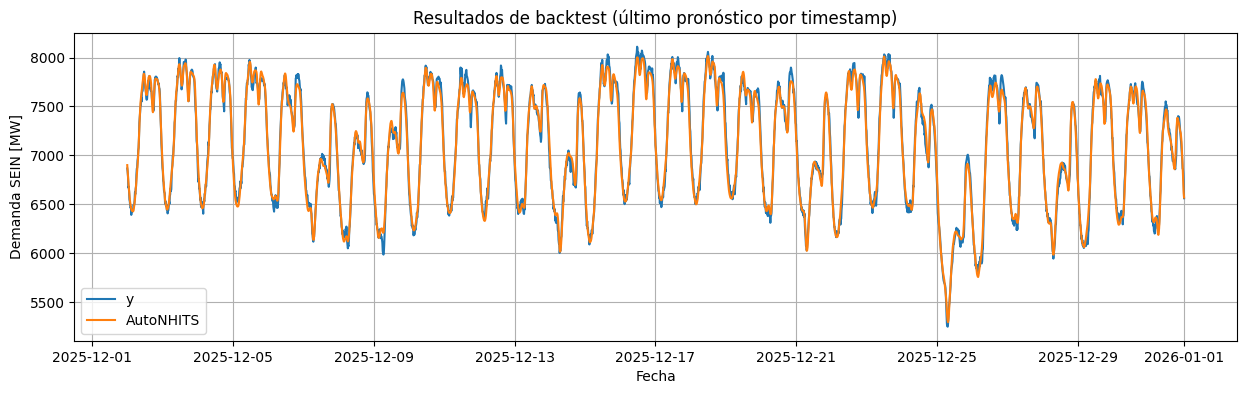

In [24]:
# Plot results
fig, ax = plt.subplots()
fig.set_size_inches(15,4)
ax.plot(latest_prediction_points, label=latest_prediction_points.columns)
ax.grid()
ax.legend()
ax.set_ylabel("Demanda SEIN [MW]")
ax.set_xlabel("Fecha")
ax.set_title("Resultados de backtest (último pronóstico por timestamp)")

Text(0.5, 1.0, 'Resultados de backtest (todas los pronósticos)')

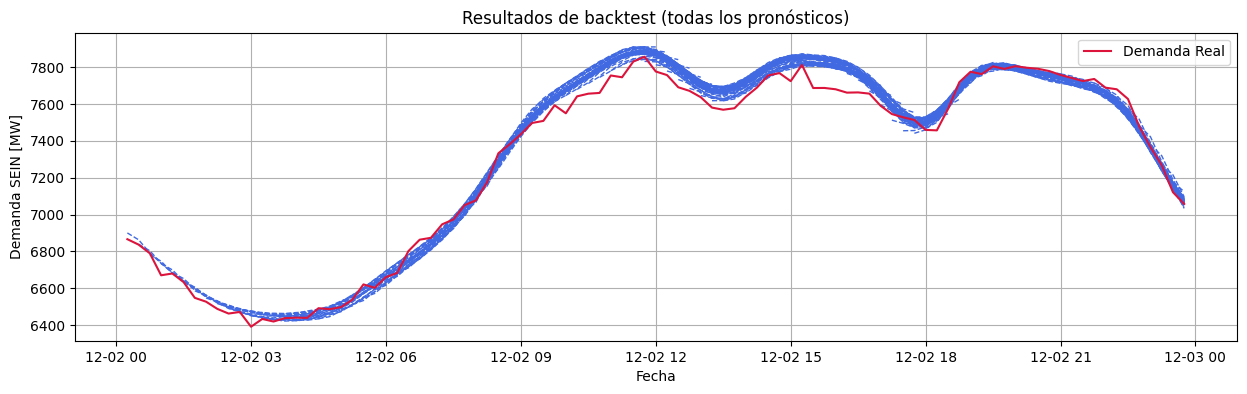

In [52]:
# Plot results
fig, ax = plt.subplots()
fig.set_size_inches(15,4)
predictions_plot = predictions.set_index("ds")
predictions_plot = predictions_plot.loc["2025-12-01": "2025-12-02"]
for cutoff in predictions_plot["cutoff"].unique():
    pred = predictions_plot.loc[predictions_plot["cutoff"] == cutoff, "AutoNHITS"]
    ax.plot(
        pred,
        color="royalblue",
        linestyle="--",
        linewidth=1,
    )

ax.plot(latest_prediction_points.loc["2025-12-01": "2025-12-02", "y"],
        color="crimson",
        label=["Demanda Real"])
ax.grid()
ax.legend()
ax.set_ylabel("Demanda SEIN [MW]")
ax.set_xlabel("Fecha")
ax.set_title("Resultados de backtest (todas los pronósticos)")

### Performance on test set

In [64]:
mae= mean_absolute_error(predictions["y"], predictions["AutoNHITS"])
mape = mean_absolute_percentage_error(predictions["y"], predictions["AutoNHITS"])
mse = mean_squared_error(predictions["y"], predictions["AutoNHITS"])
rmse = root_mean_squared_error(predictions["y"], predictions["AutoNHITS"])

print("NHITS error metrics")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

NHITS error metrics
MAE: 63.93
MAPE: 0.90%
MSE: 6759.40
RMSE: 82.22


### Peak prediction

In [144]:
real_peaks = df_test[["ds", "y"]].set_index("ds").between_time("17:15", "23:00")
real_peaks = real_peaks["y"].resample("d").apply(lambda x: [x.idxmax(), x.max()])
real_peaks = pd.DataFrame.from_records(real_peaks, columns=["timestamp_real_peak", "real_value"])
real_peaks["date"] = real_peaks["timestamp_real_peak"].dt.date

pred_peaks = latest_prediction_points[["AutoNHITS"]].between_time("17:15", "23:00")
pred_peaks = pred_peaks["AutoNHITS"].resample("d").apply(lambda x: [x.idxmax(), x.max()])
pred_peaks = pd.DataFrame.from_records(pred_peaks, columns=["timestamp_pred_peak", "pred_value"])
pred_peaks["date"] = pred_peaks["timestamp_pred_peak"].dt.date

peak_comparisson = pd.merge(real_peaks, pred_peaks, on="date", how="right")
minutes_difference = abs(
    peak_comparisson["timestamp_real_peak"]
    - peak_comparisson["timestamp_pred_peak"]
).dt.total_seconds()/60

peak_comparisson["minutes_difference"] = minutes_difference

peak_comparisson

,timestamp_real_peak,real_value,date,timestamp_pred_peak,pred_value,minutes_difference
0,2025-12-02 20:00:00,7805.07295,2025-12-02,2025-12-02 19:30:00,7786.047852,30.0
1,2025-12-03 20:15:00,7877.15890,2025-12-03,2025-12-03 19:30:00,7856.635742,45.0
2,2025-12-04 19:45:00,7797.13088,2025-12-04,2025-12-04 19:30:00,7842.486328,15.0
3,2025-12-05 19:45:00,7788.67375,2025-12-05,2025-12-05 19:30:00,7858.152344,15.0
4,2025-12-06 20:45:00,7831.24835,2025-12-06,2025-12-06 20:00:00,7728.229492,45.0
5,2025-12-07 20:00:00,7525.13029,2025-12-07,2025-12-07 20:00:00,7523.202148,0.0
6,2025-12-08 19:45:00,7644.85160,2025-12-08,2025-12-08 20:00:00,7582.815918,15.0
7,2025-12-09 20:00:00,7777.39071,2025-12-09,2025-12-09 20:00:00,7640.299316,0.0
8,2025-12-10 20:15:00,7805.35788,2025-12-10,2025-12-10 19:30:00,7752.202637,45.0
9,2025-12-11 19:45:00,7664.50907,2025-12-11,2025-12-11 19:30:00,7653.102539,15.0


In [148]:
mean_peak_drift = peak_comparisson["minutes_difference"].mean()
print("Mean peak drift:", mean_peak_drift, "minutes")

Mean peak drift: 28.0 minutes


<Axes: xlabel='date', ylabel='Difference minutes  (+/-)'>

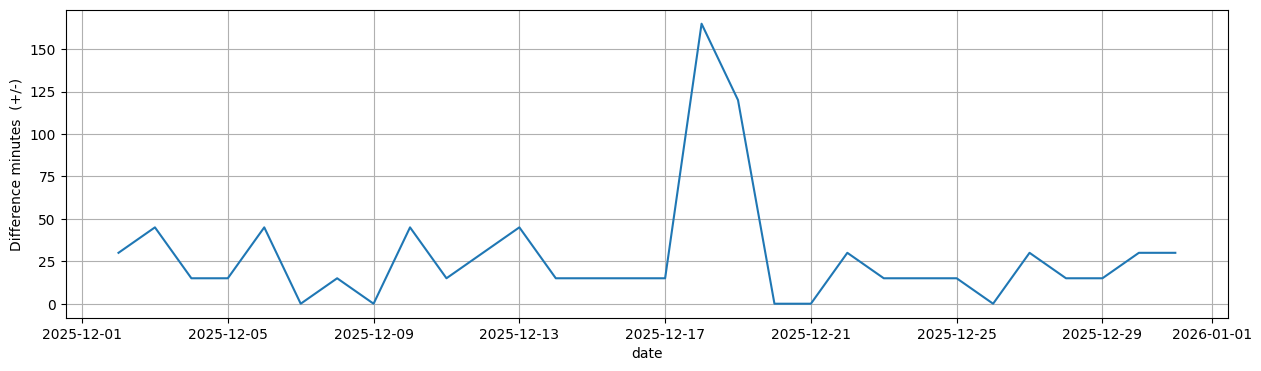

In [145]:
peak_comparisson.set_index("date")["minutes_difference"].plot(ylabel="Difference minutes  (+/-)", figsize=(15,4), grid=True)